# Applied data principles 

#### based on Comprehensive data exploration with Python by https://www.pmarcelino.com/

1. **Understand the problem**. We'll look at each variable and do a philosophical analysis about their meaning and importance for this problem.
2. **Univariable study**. We'll just focus on the dependent variable ('Fare') and try to know a little bit more about it.
3. **Multivariate study**. We'll try to understand how the dependent variable and independent variables relate.
4. **Basic cleaning**. We'll clean the dataset and handle the missing data, outliers and categorical variables.
5. **Test assumptions**. We'll check if our data meets the assumptions required by most multivariate techniques.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df_train = pd.read_csv('input/train.csv')

In [3]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Understand the problem

let's choose the 'Pclass' and 'Survived'

In [4]:
#descriptive statistics summary
df_train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

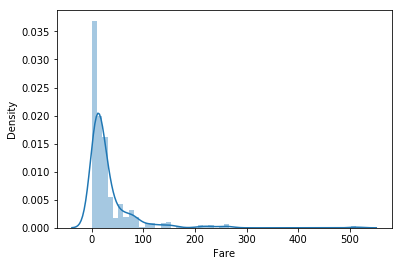

In [5]:
#histogram
sns.distplot(df_train['Fare']);

- deviate from normal distribution.
- positive skewness

In [6]:
#skewness and kurtosis
print("Skewness: %f" % df_train['Fare'].skew())
print("Kurtosis: %f" % df_train['Fare'].kurt())

Skewness: 4.787317
Kurtosis: 33.398141


Relationship with numerical variables

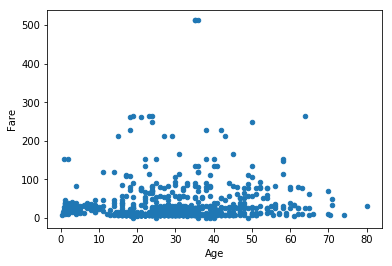

In [7]:
data = df_train
data.plot.scatter(x='Age', y='Fare');

Correlation matrix (heatmap style)

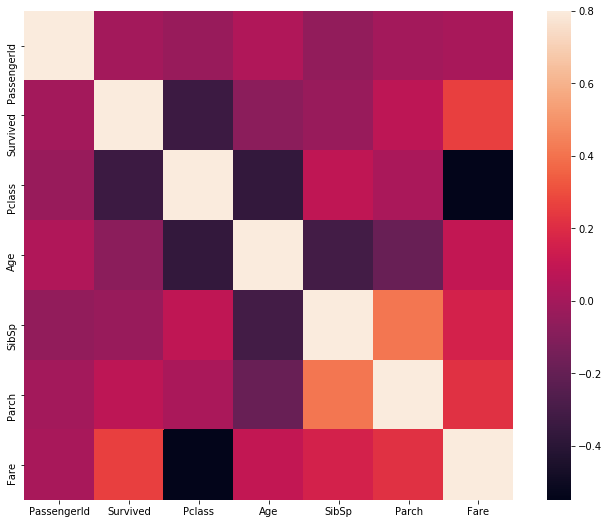

In [8]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

- heatmap is the best way to get a quick overview of our 'plasma soup' and its relationships
-  cases show how significant the correlation is between these variables. Actually, this correlation is so strong that it can indicate a situation of multicollinearity. If we think about these variables, we can conclude that they give almost the same information so multicollinearity really occurs. Heatmaps are great to detect this kind of situations and in problems dominated by feature selection, like ours, they are an essential tool
- *survived* and *Pclass* have strong negative correlation
- *Fare* and *survived* seem to have positive correlation
- passenger id, as expected, shows no contribution (-0.005)

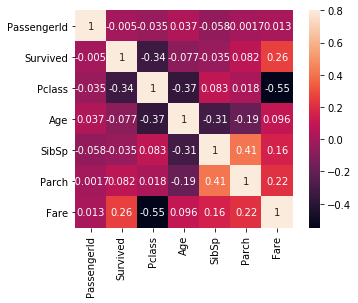

In [9]:
sns.heatmap(corrmat, annot=True, vmax=.8, square=True);

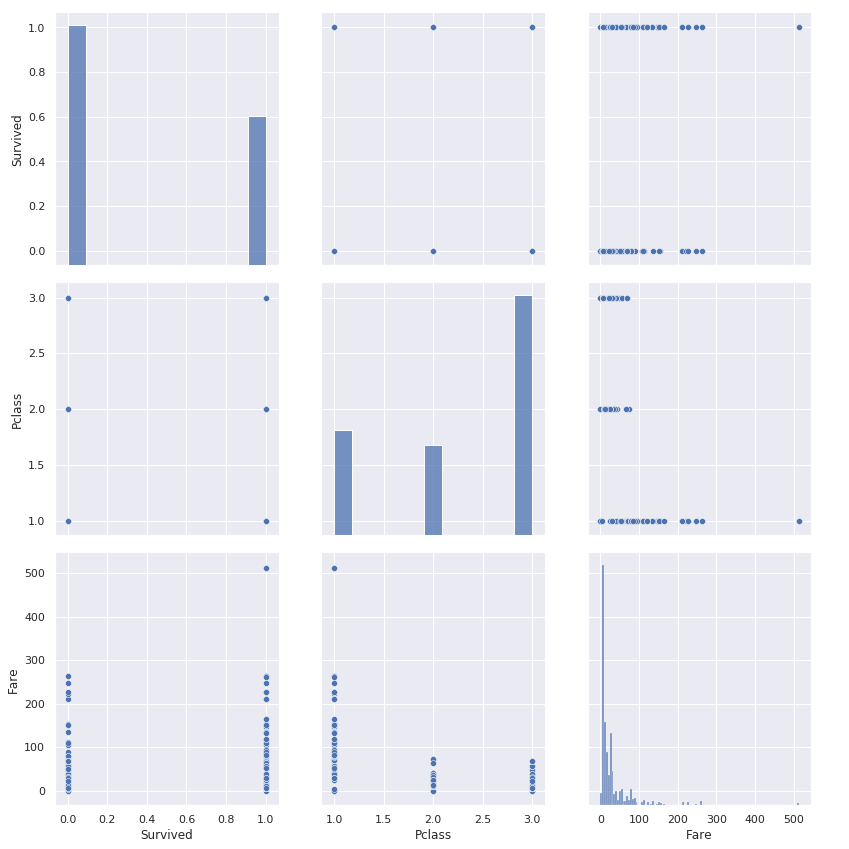

In [10]:
sns.set()
cols = ['Survived', 'Pclass', 'Fare'] #, 'Parch', 'Age'
sns.pairplot(df_train[cols], size = 4)
plt.show();

### 4. Missing data

Important questions when thinking about missing data:

How prevalent is the missing data?
Is missing data random or does it have a pattern?

The answer to these questions is important for practical reasons because missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis. Moreover, from a substantive perspective, we need to ensure that the missing data process is not biased and hidding an inconvenient truth.

In [11]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


We'll consider that when more than 15% of the data is missing, we should delete the corresponding variable and pretend it never existed. This means that we will not try any trick to fill the missing data in these cases. According to this, there is a set of variables (e.g. 'Cabin', 'Age', etc.) that we should delete.

In summary, to handle missing data, we'll delete all the variables with missing data, except the variable 'Embarked'. In 'Embarked' we'll just delete the observation with missing data.

In [12]:
#dealing with missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 2]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Embarked'].isnull()].index)
df_train.isnull().sum().max() #just checking that there's no missing data missing...

0

In [13]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,S


### Out liars!

Outliers is also something that we should be aware of. Why? Because outliers can markedly affect our models and can be a valuable source of information, providing us insights about specific behaviours.

Outliers is a complex subject and it deserves more attention. Here, we'll just do a quick analysis through the standard deviation of 'Fare' and a set of scatter plots.

#### Univariate analysis

The primary concern here is to establish a threshold that defines an observation as an outlier. To do so, we'll standardize the data. In this context, data standardization means converting data values to have mean of 0 and a standard deviation of 1.

In [14]:
#standardizing data
fare_scaled = StandardScaler().fit_transform(df_train['Fare'][:,np.newaxis]);
low_range = fare_scaled[fare_scaled[:,0].argsort()][:10]
high_range= fare_scaled[fare_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-0.64620445]
 [-0.64620445]
 [-0.64620445]
 [-0.64620445]
 [-0.64620445]
 [-0.64620445]
 [-0.64620445]
 [-0.64620445]
 [-0.64620445]
 [-0.64620445]]

outer range (high) of the distribution:
[[4.33714701]
 [4.63620753]
 [4.63620753]
 [4.6487907 ]
 [4.6487907 ]
 [4.6487907 ]
 [4.6487907 ]
 [9.66855078]
 [9.66855078]
 [9.66855078]]


For now, we'll not consider any of these values as an outlier but we should be careful with those three 9.something values.

### Bivariate analysis

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


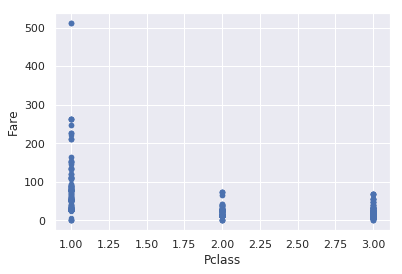

In [15]:
#bivariate analysis price/pclass
df_train.plot.scatter(x="Pclass", y='Fare');

How it was working with the non-categorical case:

What has been revealed:

- The two values seem strange and they are not following the trend -> If these two points are not representative of the typical case, we'll define them as outliers and delete them.
- The observations that we noticed before  - if they look like two special cases but seem to be following the trend -> then we will keep them.

### 5. Test assumptions

 Now it's time to go deep and understand how 'Fare' complies with the statistical assumptions that enables us to apply multivariate techniques.

According to Hair et al. (2013), four assumptions should be tested:

- **Normality** - When we talk about normality what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'Fare' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.

- **Homoscedasticity** - Homoscedasticity refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)' (Hair et al., 2013). Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.

- **Linearity**- The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.

- **Absence of correlated errors** - Correlated errors, like the definition suggests, happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. This occurs often in time series, where some patterns are time related. We'll also not get into this. However, if you detect something, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors.

### In search of normality

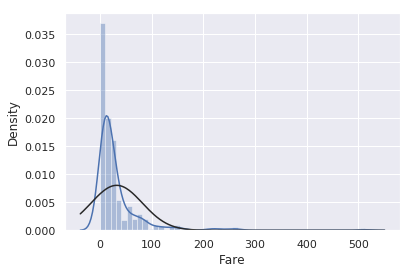

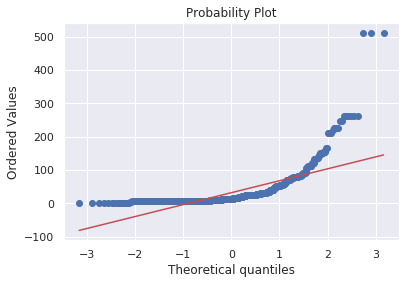

In [16]:
#histogram and normal probability plot
sns.distplot(df_train['Fare'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['Fare'], plot=plt)

- not normal
- 'peakedness', positive skewness and does not follow the diagonal line
- A simple data transformation can solve the problem. This is one of the awesome things you can learn in statistical books: in case of positive skewness, log transformations usually works well. 

#### Before log transformation drop all zeros (so it does not go to infinity)

- so here comes interesting part - we can see that with log model we are trying to transform 0, but log0 goes to inf
- we can either drop the values in the following way shown below - however the question stays! We are going to adress this issue with the recent study on the subject

In [17]:
df_train['Fare'] = df_train['Fare'].replace(0, np.nan)

In [18]:
print(df_train['Fare'].to_string())

0        7.2500
1       71.2833
2        7.9250
3       53.1000
4        8.0500
5        8.4583
6       51.8625
7       21.0750
8       11.1333
9       30.0708
10      16.7000
11      26.5500
12       8.0500
13      31.2750
14       7.8542
15      16.0000
16      29.1250
17      13.0000
18      18.0000
19       7.2250
20      26.0000
21      13.0000
22       8.0292
23      35.5000
24      21.0750
25      31.3875
26       7.2250
27     263.0000
28       7.8792
29       7.8958
30      27.7208
31     146.5208
32       7.7500
33      10.5000
34      82.1708
35      52.0000
36       7.2292
37       8.0500
38      18.0000
39      11.2417
40       9.4750
41      21.0000
42       7.8958
43      41.5792
44       7.8792
45       8.0500
46      15.5000
47       7.7500
48      21.6792
49      17.8000
50      39.6875
51       7.8000
52      76.7292
53      26.0000
54      61.9792
55      35.5000
56      10.5000
57       7.2292
58      27.7500
59      46.9000
60       7.2292
62      83.4750
63      

In [19]:
df_train = df_train.drop(df_train.loc[df_train['Fare'].isnull()].index)

In [20]:
### dropping 0
print(df_train['Fare'].to_string())

0        7.2500
1       71.2833
2        7.9250
3       53.1000
4        8.0500
5        8.4583
6       51.8625
7       21.0750
8       11.1333
9       30.0708
10      16.7000
11      26.5500
12       8.0500
13      31.2750
14       7.8542
15      16.0000
16      29.1250
17      13.0000
18      18.0000
19       7.2250
20      26.0000
21      13.0000
22       8.0292
23      35.5000
24      21.0750
25      31.3875
26       7.2250
27     263.0000
28       7.8792
29       7.8958
30      27.7208
31     146.5208
32       7.7500
33      10.5000
34      82.1708
35      52.0000
36       7.2292
37       8.0500
38      18.0000
39      11.2417
40       9.4750
41      21.0000
42       7.8958
43      41.5792
44       7.8792
45       8.0500
46      15.5000
47       7.7500
48      21.6792
49      17.8000
50      39.6875
51       7.8000
52      76.7292
53      26.0000
54      61.9792
55      35.5000
56      10.5000
57       7.2292
58      27.7500
59      46.9000
60       7.2292
62      83.4750
63      

In [21]:
#applying log transformation
df_train['Fare'] = np.log(df_train['Fare'])

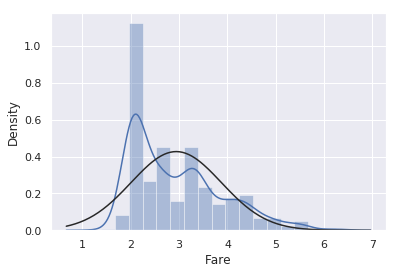

In [22]:
#transformed histogram and normal probability plot
sns.distplot(df_train['Fare'], fit=norm)

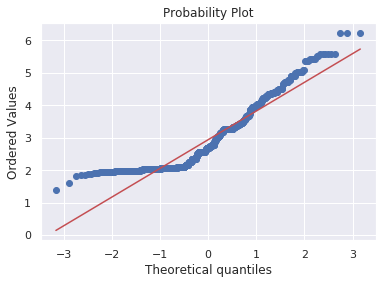

In [23]:
fig = plt.figure()
res = stats.probplot(df_train['Fare'], plot=plt)

**Log transformation of values that include 0 (zero) for statistical analyses:**
- **Q.** When trying to search for linear relationships between variables in my data I seldom come across "0" (zero) values, which I have to remove to be able to work with Log transformation (normalisation) of the data. However, it would be important to consider these values in the analysis. How can I do this? Should I assign a very low number to the missing data?

- **Answer 1** Ask yourself if a **multiplicative model** (*) is appropriate for your data. 

    - Having (a considerable amount of) zero values indicates that there might be a problem, either with data generation (truncation, rounding errors, sensitivity limit,...) or that the data generating process might not be multiplicative. **This could be a warn signal not to simply log-transform the data.** 
    - One has to think about the whole experiment and process to proceed. It may turn out that you are measuring kinds of concentrations, where a gamma model might be appropriate, or counts, where a poisson model or a negative binomial model would be indicated, or something else. 
    - **Change the model instead of using a transformation to use the "standard" model** (i.e. a model with normal distributed residuals) or  **delete the values, if there are not too many of them.**

- **Answer 2** Consider the recent study of https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3444996

    - Citation: Bellégo, Christophe and Pape, Louis-Daniel, Dealing with Logs and Zeros in Regression Models (August 28, 2019). Série des Documents de Travail n° 2019-13, Available at SSRN: https://ssrn.com/abstract=3444996 or http://dx.doi.org/10.2139/ssrn.3444996

### Here we would point out the main results from the paper "Dealing with Logs and Zeros in Regression Models":
- PPML estimator: Pseudo-Poisson Maximum Likelihood
- complementary solution: adding a positive constant to the dependent variable, which is useful when PPML faces numerical issues
    - given that the most intuitive way to handle zeros amounts to adding a positive constant to the data points, our solution consists in **adding an optimal positive value ∆i (which varies over observations) that does not generate correlation between the error term and the regressors**
    - does not require the deletion of observations, the estimation of a supplementary parameter, or the addition of a discretionary constant
    - only **relies on the independence between the error term and the covariates**
    

1. yi =exp(α+xi′β)εi
2. yi +∆i =exp(α+xi′β)εi +∆i
3. yi +exp(xi′β)=exp(α+xi′β)εi +exp(xi′β)=exp(xi′β)(1+exp(α)εi)
4. since yi+exp(xi′β) is non-negative for any observation, we get 
    - log(yi +exp(xi′β))=xi′β+log(1+exp(α)εi)
5. ηi = log(1 + exp (α)εi )
    - log(yi +exp(xi′β))=xi′β+ηi (6)

    
- Therefore, the parameter β can be identified using all observations, included those where y = 0
- expectation and 2nd moment of (6) suggest estimation through the non-linear generalized method of moment (GMM)

Stata:
`gmm (log(y+exp({xb:x}))-{xb:}-{lambda}), instruments(x) wmatrix(robust)`


#### second log transformation

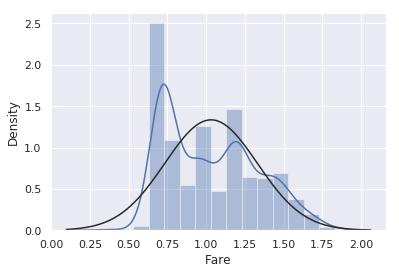

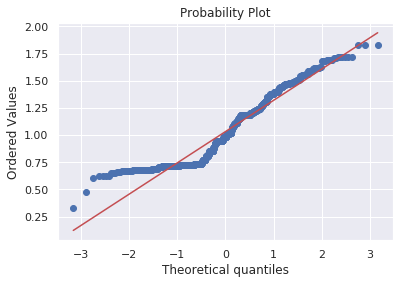

In [24]:
#applying log transformation
df_train['Fare'] = np.log(df_train['Fare'])
#transformed histogram and normal probability plot
sns.distplot(df_train['Fare'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['Fare'], plot=plt)

- we can clearly see that this transformation is multimodal
- perform on other numerical variables (however, we have none)

#### Homoscedasticity
The best approach to test homoscedasticity for two metric variables is graphically. Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution).

In [25]:
df_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,0.683603,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,1.450832,C


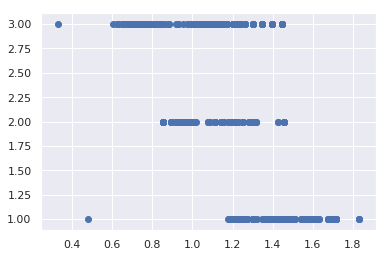

In [26]:
#scatter plot
plt.scatter(df_train['Fare'], df_train['Pclass']);

In [32]:
#convert categorical variable into dummy
# the easy, but totally not convinient way to convert to categorical
# see notebook with Titanic
df_train = pd.get_dummies(df_train)

In [31]:
df_train.head(2)

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,"Name_Abbing, Mr. Anthony","Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)","Name_Abelson, Mr. Samuel",...,Ticket_W./C. 14263,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,1,0,0.683603,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,1,0,1.450832,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
